# GPT-2 Fine-Tuning on iCliniq

reference: https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/

## Setup

In [1]:
import torch

In [2]:
torch.cuda.empty_cache()

In [3]:
!ls

Copy_of_BERT_Classifier.ipynb  __MACOSX		   new_dataset.csv  train.csv
dataset2.csv		       medquad.csv	   nltk_data
GPT2_v2.ipynb		       MedQuAD-master	   predicted.csv
GPT_Classification.ipynb       MedQuAD-master.zip  test.csv


In [4]:
import os
import json
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
#% matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

2023-05-28 18:49:34.056301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-28 18:49:34.250063: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-28 18:49:34.286836: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-28 18:49:34.880431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

True

# Create Training Set

In [7]:
df = pd.read_csv('dataset2.csv') 
#read medquad
df.head()

,Unnamed: 0,Question,Answer
0,0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...
1,1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...
2,2,my son is 13 and is depressed. he has been tak...,while any of the stimulant medications can inc...
3,3,my 17-year-old has stopped taking concerta aft...,seventy percent of teens diagnosed when they a...
4,4,i've been taking respa-ar for allergies. i can...,try claritin-d which is located behind the pha...


In [8]:
# Clean Data
df['Question'] = df['Question'].astype(str)
df['Answer'] = df['Answer'].astype(str)
#df['summary'] = df['summary'].astype(str)

# drop NA's
df = df.dropna()
df.head()

,Unnamed: 0,Question,Answer
0,0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...
1,1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...
2,2,my son is 13 and is depressed. he has been tak...,while any of the stimulant medications can inc...
3,3,my 17-year-old has stopped taking concerta aft...,seventy percent of teens diagnosed when they a...
4,4,i've been taking respa-ar for allergies. i can...,try claritin-d which is located behind the pha...


In [9]:
# Add marks for original promp and repsonse marks
df['Question'] = '[WP]' + df['Question'] # + '?'
df['Answer'] = '\n[RESPONSE]' + df['Answer']
df.head()

,Unnamed: 0,Question,Answer
0,0,[WP]my 5 1/2-year-old son displays adhd sympto...,\n[RESPONSE]adhd and bipolar mood disorder (bm...
1,1,[WP]my son has add and mild autism. he has bee...,\n[RESPONSE]stimulants in general tend to decr...
2,2,[WP]my son is 13 and is depressed. he has been...,\n[RESPONSE]while any of the stimulant medicat...
3,3,[WP]my 17-year-old has stopped taking concerta...,\n[RESPONSE]seventy percent of teens diagnosed...
4,4,[WP]i've been taking respa-ar for allergies. i...,\n[RESPONSE]try claritin-d which is located be...


In [10]:
# Define a function to count the number of words in a string
def count_words(text):
    return len(text.split())

# Create a boolean mask indicating which rows have more than 300 words
mask = df['Answer'].apply(count_words) > 150

# Filter out the rows with more than 300 words
df = df.loc[~mask]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24911 entries, 4 to 29751
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  24911 non-null  int64 
 1   Question    24911 non-null  object
 2   Answer      24911 non-null  object
dtypes: int64(1), object(2)
memory usage: 778.5+ KB


In [13]:
# merge into one
qa_pair = df["Question"] + df["Answer"] # \n vs ' ' ???

qa_pair.head()

4    [WP]i've been taking respa-ar for allergies. i...
6    [WP]my daughter is 15 months old has had sever...
7    [WP]does your body know how many calories you ...
8    [WP]i have trouble swallowing pills. can my pr...
9    [WP]i need a list of foods that i can eat and ...
dtype: object

In [14]:
small_sample = qa_pair.sample(300)

In [15]:
replace_dict = {'[WP]': '!'}
#small_sample = pd.Series(small_sample)
small_sample.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')


14992    [WP]hi. i've taken several pregnancy test all ...
4518     [WP]i had a transplant 3 years ago and i would...
25726    [WP]i have two holes in my chest that blow blo...
8772     [WP]i have naval bleeding and a little bit of ...
12621    [WP]treatment for household cleaning product a...
                               ...                        
13259    [WP]i got stitches and a filling over the stit...
14822    [WP]what is the likelyhood of getting pregnant...
12876    [WP]what can cause burning in my thighs when i...
12013    [WP]peculiar rash on the underside of my penis...
21184    [WP]i found out i was pregnant the first of th...
Length: 300, dtype: object

In [16]:
def clean_text(text):
    #text = text.replace('\n','')
    text = text.replace('``', '')
    text = text.replace('"', '')
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text

check length

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

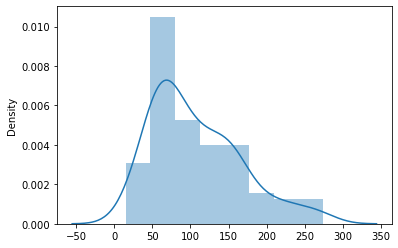

In [18]:
doc_lengths = []

for howto in qa_pair.sample(n=100):

    # get rough token count distribution
    tokens = nltk.word_tokenize(howto)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [19]:
# the max token length   
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.0

In [20]:
np.average(doc_lengths)

107.53

# GPT2 Tokenizer

In [21]:
# NOTE: EMBEDDING SIZE NOT LARGE ENOUGH!!! -- SHOULD USE LARGER MODEL
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# PyTorch Datasets & Dataloaders


Testing I managed to run it in 4 using Paperspace PRO machines

In [22]:
batch_size = 2

In [23]:
def clean_text(text):
    text = text.replace('\n\n\n\n','\n').replace('\n\n\n','\n').replace('\n ','\n')
    text = text.replace('``', '').replace('.;', '.')
    text = text.replace('"', '').replace("\n,", "").replace("\n, ", "")
    text = text.replace("\n,\n", "").replace(".,", ".").replace('"', '').replace('\n;\n','')
    text = text.replace(" ,", ",").replace(" .", ".").replace(" %", "%")
    text = text.replace(" - ", "-").replace(" : ", ":").replace(" / ", "/")
    text = text.replace("( ", "(").replace(" )", ")")
    #text = text.replace("`` ", "\"").replace(" ''", "\"")
    text = text.replace(" 's", "'s").replace("s ' ", "s' ")
    return text
    
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="distilgpt2", max_length=1024):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:
    
      text = txt #= clean_text(txt)
      encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [24]:
dataset = GPT2Dataset(qa_pair, tokenizer, max_length=512)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

19,928 training samples
4,983 validation samples


In [25]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Fine-tune

In [26]:
configuration = GPT2Config.from_pretrained('distilgpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("distilgpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
# some parameters I cooked up that work reasonably well
epochs = 3
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8
check_path = './checkpoints'



# this produces sample output every 100 steps
sample_every = 100

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
# checkpoint
#torch.save({
#            'epoch': epochs,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, check_path)

/home/nyagnik/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [30]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [31]:
torch.cuda.empty_cache()

### Training

In [32]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # print examples of generated outputs
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
#            for i, sample_output in enumerate(sample_outputs):
#                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,964. Loss: 0.8604654669761658.   Elapsed: 0:00:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,964. Loss: 0.6051168441772461.   Elapsed: 0:00:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,964. Loss: 1.440451741218567.   Elapsed: 0:00:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,964. Loss: 1.1915513277053833.   Elapsed: 0:00:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,964. Loss: 1.4761779308319092.   Elapsed: 0:00:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,964. Loss: 0.6457312703132629.   Elapsed: 0:00:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,964. Loss: 1.4195685386657715.   Elapsed: 0:01:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,964. Loss: 0.5381470322608948.   Elapsed: 0:01:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,964. Loss: 0.9228374361991882.   Elapsed: 0:01:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,964. Loss: 1.094482421875.   Elapsed: 0:01:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,964. Loss: 0.610371470451355.   Elapsed: 0:01:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,964. Loss: 0.6931449770927429.   Elapsed: 0:01:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,964. Loss: 0.41385528445243835.   Elapsed: 0:01:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,964. Loss: 0.6038203835487366.   Elapsed: 0:02:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,964. Loss: 0.6278191208839417.   Elapsed: 0:02:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,964. Loss: 0.6187862157821655.   Elapsed: 0:02:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,964. Loss: 1.2654699087142944.   Elapsed: 0:02:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,964. Loss: 1.1667042970657349.   Elapsed: 0:02:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,964. Loss: 1.0867046117782593.   Elapsed: 0:02:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,964. Loss: 0.8365617394447327.   Elapsed: 0:03:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,964. Loss: 0.8398101329803467.   Elapsed: 0:03:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,964. Loss: 0.8184829354286194.   Elapsed: 0:03:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,964. Loss: 0.8597140312194824.   Elapsed: 0:03:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,964. Loss: 1.103838324546814.   Elapsed: 0:03:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,964. Loss: 0.6728600859642029.   Elapsed: 0:03:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,964. Loss: 0.7219604253768921.   Elapsed: 0:03:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,964. Loss: 1.3132387399673462.   Elapsed: 0:04:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,964. Loss: 0.5392300486564636.   Elapsed: 0:04:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,964. Loss: 0.8784235715866089.   Elapsed: 0:04:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,964. Loss: 0.5594013929367065.   Elapsed: 0:04:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,964. Loss: 0.547480583190918.   Elapsed: 0:04:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,964. Loss: 0.9125113487243652.   Elapsed: 0:04:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,964. Loss: 0.5980375409126282.   Elapsed: 0:04:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,964. Loss: 0.8677225112915039.   Elapsed: 0:05:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,964. Loss: 1.2801400423049927.   Elapsed: 0:05:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,964. Loss: 1.0600181818008423.   Elapsed: 0:05:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,964. Loss: 0.9863766431808472.   Elapsed: 0:05:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,964. Loss: 0.8279370665550232.   Elapsed: 0:05:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,964. Loss: 0.6926814913749695.   Elapsed: 0:05:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,964. Loss: 0.9768646359443665.   Elapsed: 0:06:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,964. Loss: 0.9300357103347778.   Elapsed: 0:06:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,964. Loss: 1.2521580457687378.   Elapsed: 0:06:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,964. Loss: 0.9337242245674133.   Elapsed: 0:06:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,964. Loss: 0.5054798722267151.   Elapsed: 0:06:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,964. Loss: 0.4491605758666992.   Elapsed: 0:06:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,964. Loss: 0.9656892418861389.   Elapsed: 0:06:55.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,964. Loss: 0.7922956347465515.   Elapsed: 0:07:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,964. Loss: 0.5146302580833435.   Elapsed: 0:07:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,964. Loss: 0.8433433175086975.   Elapsed: 0:07:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,964. Loss: 0.5898658633232117.   Elapsed: 0:07:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,964. Loss: 0.5979987978935242.   Elapsed: 0:07:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,964. Loss: 0.673548698425293.   Elapsed: 0:07:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,964. Loss: 1.9691643714904785.   Elapsed: 0:08:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,964. Loss: 0.7570769190788269.   Elapsed: 0:08:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,964. Loss: 0.7071026563644409.   Elapsed: 0:08:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,964. Loss: 1.376844882965088.   Elapsed: 0:08:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,964. Loss: 1.4558472633361816.   Elapsed: 0:08:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,964. Loss: 0.7739967107772827.   Elapsed: 0:08:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,964. Loss: 0.4213052988052368.   Elapsed: 0:08:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,964. Loss: 0.6472270488739014.   Elapsed: 0:09:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,964. Loss: 1.3890413045883179.   Elapsed: 0:09:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,964. Loss: 1.1738630533218384.   Elapsed: 0:09:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,964. Loss: 0.9424729347229004.   Elapsed: 0:09:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,964. Loss: 0.5088117718696594.   Elapsed: 0:09:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,964. Loss: 0.9997848868370056.   Elapsed: 0:09:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,964. Loss: 0.4467528760433197.   Elapsed: 0:09:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,964. Loss: 0.5116379261016846.   Elapsed: 0:10:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,964. Loss: 0.5519317388534546.   Elapsed: 0:10:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,964. Loss: 0.8097506165504456.   Elapsed: 0:10:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,964. Loss: 0.6596608757972717.   Elapsed: 0:10:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,964. Loss: 0.8425202369689941.   Elapsed: 0:10:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,964. Loss: 1.0645079612731934.   Elapsed: 0:10:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,964. Loss: 0.5925244688987732.   Elapsed: 0:11:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,964. Loss: 0.6165369153022766.   Elapsed: 0:11:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,964. Loss: 0.6961163878440857.   Elapsed: 0:11:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,964. Loss: 0.8235873579978943.   Elapsed: 0:11:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,964. Loss: 1.2003581523895264.   Elapsed: 0:11:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,964. Loss: 0.7646220326423645.   Elapsed: 0:11:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,964. Loss: 0.7278091311454773.   Elapsed: 0:11:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,964. Loss: 0.7316079139709473.   Elapsed: 0:12:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,964. Loss: 1.1350913047790527.   Elapsed: 0:12:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,964. Loss: 0.6536346673965454.   Elapsed: 0:12:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,964. Loss: 1.253534197807312.   Elapsed: 0:12:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,964. Loss: 0.7020125985145569.   Elapsed: 0:12:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,964. Loss: 0.6879705786705017.   Elapsed: 0:12:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,964. Loss: 0.5335476994514465.   Elapsed: 0:13:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,964. Loss: 0.5901650786399841.   Elapsed: 0:13:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,964. Loss: 1.2687522172927856.   Elapsed: 0:13:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,964. Loss: 0.707522988319397.   Elapsed: 0:13:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,964. Loss: 0.7263933420181274.   Elapsed: 0:13:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,964. Loss: 1.176345705986023.   Elapsed: 0:13:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,964. Loss: 0.7100655436515808.   Elapsed: 0:13:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,964. Loss: 0.6534501314163208.   Elapsed: 0:14:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,964. Loss: 0.5399489402770996.   Elapsed: 0:14:13.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,964. Loss: 1.0701777935028076.   Elapsed: 0:14:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,964. Loss: 0.5444507002830505.   Elapsed: 0:14:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  9,964. Loss: 1.2986488342285156.   Elapsed: 0:14:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  9,964. Loss: 0.6032333970069885.   Elapsed: 0:14:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  9,964. Loss: 0.9607298970222473.   Elapsed: 0:14:58.

  Average training loss: 0.82
  Training epoch took: 0:15:04

Running Validation...
  Validation Loss: 0.75
  Validation took: 0:00:59

======== Epoch 2 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,964. Loss: 0.821662187576294.   Elapsed: 0:00:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,964. Loss: 1.084997534751892.   Elapsed: 0:00:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,964. Loss: 0.5757496356964111.   Elapsed: 0:00:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,964. Loss: 0.6749154925346375.   Elapsed: 0:00:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,964. Loss: 0.7946361303329468.   Elapsed: 0:00:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,964. Loss: 0.4421522319316864.   Elapsed: 0:00:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,964. Loss: 0.6762149333953857.   Elapsed: 0:01:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,964. Loss: 0.31806549429893494.   Elapsed: 0:01:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,964. Loss: 0.7392317652702332.   Elapsed: 0:01:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,964. Loss: 0.7821499109268188.   Elapsed: 0:01:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,964. Loss: 0.43996894359588623.   Elapsed: 0:01:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,964. Loss: 0.4635823965072632.   Elapsed: 0:01:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,964. Loss: 0.8840312361717224.   Elapsed: 0:01:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,964. Loss: 0.30823755264282227.   Elapsed: 0:02:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,964. Loss: 0.24923811852931976.   Elapsed: 0:02:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,964. Loss: 0.5230585336685181.   Elapsed: 0:02:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,964. Loss: 0.3077988624572754.   Elapsed: 0:02:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,964. Loss: 0.8835683465003967.   Elapsed: 0:02:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,964. Loss: 0.45224928855895996.   Elapsed: 0:02:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,964. Loss: 0.4356216788291931.   Elapsed: 0:02:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,964. Loss: 0.8423771262168884.   Elapsed: 0:03:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,964. Loss: 0.5162872672080994.   Elapsed: 0:03:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,964. Loss: 0.9153503775596619.   Elapsed: 0:03:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,964. Loss: 1.2174186706542969.   Elapsed: 0:03:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,964. Loss: 0.3557529151439667.   Elapsed: 0:03:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,964. Loss: 0.7925713062286377.   Elapsed: 0:03:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,964. Loss: 1.1307382583618164.   Elapsed: 0:04:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,964. Loss: 1.1913951635360718.   Elapsed: 0:04:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,964. Loss: 0.935945987701416.   Elapsed: 0:04:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,964. Loss: 0.9960481524467468.   Elapsed: 0:04:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,964. Loss: 0.9552839994430542.   Elapsed: 0:04:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,964. Loss: 0.7256103157997131.   Elapsed: 0:04:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,964. Loss: 1.3700108528137207.   Elapsed: 0:04:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,964. Loss: 0.45400625467300415.   Elapsed: 0:05:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,964. Loss: 0.18298877775669098.   Elapsed: 0:05:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,964. Loss: 0.9019106030464172.   Elapsed: 0:05:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,964. Loss: 0.6358520984649658.   Elapsed: 0:05:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,964. Loss: 0.3813769817352295.   Elapsed: 0:05:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,964. Loss: 0.8974980711936951.   Elapsed: 0:05:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,964. Loss: 0.7287113666534424.   Elapsed: 0:05:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,964. Loss: 0.35567015409469604.   Elapsed: 0:06:09.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,964. Loss: 1.131837010383606.   Elapsed: 0:06:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,964. Loss: 0.8767107725143433.   Elapsed: 0:06:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,964. Loss: 1.2920565605163574.   Elapsed: 0:06:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,964. Loss: 0.45190057158470154.   Elapsed: 0:06:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,964. Loss: 1.1974538564682007.   Elapsed: 0:06:54.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,964. Loss: 0.5092684626579285.   Elapsed: 0:07:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,964. Loss: 0.6919716596603394.   Elapsed: 0:07:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,964. Loss: 0.5474167466163635.   Elapsed: 0:07:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,964. Loss: 1.1643556356430054.   Elapsed: 0:07:31.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,964. Loss: 0.4058970808982849.   Elapsed: 0:07:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,964. Loss: 0.33458462357521057.   Elapsed: 0:07:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,964. Loss: 0.9162700772285461.   Elapsed: 0:07:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,964. Loss: 0.4833486080169678.   Elapsed: 0:08:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,964. Loss: 0.5390543341636658.   Elapsed: 0:08:16.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,964. Loss: 0.4312319755554199.   Elapsed: 0:08:25.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,964. Loss: 0.3098543584346771.   Elapsed: 0:08:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,964. Loss: 0.42849963903427124.   Elapsed: 0:08:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,964. Loss: 0.31979236006736755.   Elapsed: 0:08:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,964. Loss: 1.005013346672058.   Elapsed: 0:09:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,964. Loss: 0.39697882533073425.   Elapsed: 0:09:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,964. Loss: 0.6542521715164185.   Elapsed: 0:09:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,964. Loss: 0.769183874130249.   Elapsed: 0:09:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,964. Loss: 0.711546003818512.   Elapsed: 0:09:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,964. Loss: 0.20528627932071686.   Elapsed: 0:09:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,964. Loss: 0.8685475587844849.   Elapsed: 0:09:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,964. Loss: 1.4176044464111328.   Elapsed: 0:10:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,964. Loss: 0.3964737057685852.   Elapsed: 0:10:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,964. Loss: 0.5126698017120361.   Elapsed: 0:10:22.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,964. Loss: 0.7559526562690735.   Elapsed: 0:10:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,964. Loss: 0.7657543420791626.   Elapsed: 0:10:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,964. Loss: 1.4303948879241943.   Elapsed: 0:10:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,964. Loss: 0.5332647562026978.   Elapsed: 0:10:58.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,964. Loss: 0.32317110896110535.   Elapsed: 0:11:07.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,964. Loss: 0.7913325428962708.   Elapsed: 0:11:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,964. Loss: 0.7499399185180664.   Elapsed: 0:11:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,964. Loss: 0.490348219871521.   Elapsed: 0:11:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,964. Loss: 0.9905077219009399.   Elapsed: 0:11:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,964. Loss: 1.1124345064163208.   Elapsed: 0:11:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,964. Loss: 0.863052248954773.   Elapsed: 0:12:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,964. Loss: 0.45878973603248596.   Elapsed: 0:12:12.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,964. Loss: 0.3094453811645508.   Elapsed: 0:12:21.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,964. Loss: 0.5669140815734863.   Elapsed: 0:12:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,964. Loss: 1.3870322704315186.   Elapsed: 0:12:40.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,964. Loss: 0.7331380248069763.   Elapsed: 0:12:49.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,964. Loss: 0.4637196958065033.   Elapsed: 0:12:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,964. Loss: 0.9434022307395935.   Elapsed: 0:13:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,964. Loss: 0.4019281268119812.   Elapsed: 0:13:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,964. Loss: 0.9027619361877441.   Elapsed: 0:13:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,964. Loss: 0.8908612728118896.   Elapsed: 0:13:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,964. Loss: 0.6542755961418152.   Elapsed: 0:13:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,964. Loss: 0.8680518865585327.   Elapsed: 0:13:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,964. Loss: 0.46129539608955383.   Elapsed: 0:14:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,964. Loss: 0.8074697256088257.   Elapsed: 0:14:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,964. Loss: 0.40919968485832214.   Elapsed: 0:14:19.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,964. Loss: 0.6101552248001099.   Elapsed: 0:14:28.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  9,964. Loss: 0.3329726457595825.   Elapsed: 0:14:37.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  9,964. Loss: 0.4221518039703369.   Elapsed: 0:14:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  9,964. Loss: 0.40876615047454834.   Elapsed: 0:14:55.

  Average training loss: 0.69
  Training epoch took: 0:15:02

Running Validation...
  Validation Loss: 0.70
  Validation took: 0:00:59

======== Epoch 3 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  9,964. Loss: 0.35012131929397583.   Elapsed: 0:00:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  9,964. Loss: 0.6748901009559631.   Elapsed: 0:00:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  9,964. Loss: 0.4932570159435272.   Elapsed: 0:00:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  9,964. Loss: 0.395985871553421.   Elapsed: 0:00:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  9,964. Loss: 0.2703689634799957.   Elapsed: 0:00:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  9,964. Loss: 0.39086487889289856.   Elapsed: 0:00:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  9,964. Loss: 0.7375141978263855.   Elapsed: 0:01:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  9,964. Loss: 0.5237244963645935.   Elapsed: 0:01:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  9,964. Loss: 0.663558840751648.   Elapsed: 0:01:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  9,964. Loss: 0.3969971537590027.   Elapsed: 0:01:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  9,964. Loss: 1.276536226272583.   Elapsed: 0:01:39.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  9,964. Loss: 0.6912745833396912.   Elapsed: 0:01:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  9,964. Loss: 0.4503692388534546.   Elapsed: 0:01:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  9,964. Loss: 0.24988584220409393.   Elapsed: 0:02:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  9,964. Loss: 0.3633788228034973.   Elapsed: 0:02:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  9,964. Loss: 0.548589289188385.   Elapsed: 0:02:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  9,964. Loss: 0.5880154371261597.   Elapsed: 0:02:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  9,964. Loss: 0.6172180771827698.   Elapsed: 0:02:42.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  9,964. Loss: 0.288352370262146.   Elapsed: 0:02:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  9,964. Loss: 0.5850096344947815.   Elapsed: 0:02:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  9,964. Loss: 0.7705668807029724.   Elapsed: 0:03:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  9,964. Loss: 0.5928512215614319.   Elapsed: 0:03:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  9,964. Loss: 0.405649870634079.   Elapsed: 0:03:27.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  9,964. Loss: 0.6079809069633484.   Elapsed: 0:03:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  9,964. Loss: 0.40191417932510376.   Elapsed: 0:03:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  9,964. Loss: 0.2933117151260376.   Elapsed: 0:03:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  9,964. Loss: 0.9857788681983948.   Elapsed: 0:04:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  9,964. Loss: 0.5046014189720154.   Elapsed: 0:04:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  9,964. Loss: 0.5058911442756653.   Elapsed: 0:04:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  9,964. Loss: 0.2812180519104004.   Elapsed: 0:04:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  9,964. Loss: 0.8722127079963684.   Elapsed: 0:04:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  9,964. Loss: 0.460483193397522.   Elapsed: 0:04:46.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  9,964. Loss: 0.8750900030136108.   Elapsed: 0:04:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  9,964. Loss: 0.15539640188217163.   Elapsed: 0:05:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  9,964. Loss: 0.4661480188369751.   Elapsed: 0:05:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,600  of  9,964. Loss: 0.3044688105583191.   Elapsed: 0:05:23.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,700  of  9,964. Loss: 0.9662100672721863.   Elapsed: 0:05:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,800  of  9,964. Loss: 0.726626992225647.   Elapsed: 0:05:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,900  of  9,964. Loss: 1.2071807384490967.   Elapsed: 0:05:51.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,000  of  9,964. Loss: 1.0254400968551636.   Elapsed: 0:06:00.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,100  of  9,964. Loss: 0.3853379487991333.   Elapsed: 0:06:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,200  of  9,964. Loss: 0.7892876267433167.   Elapsed: 0:06:17.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,300  of  9,964. Loss: 0.5420351624488831.   Elapsed: 0:06:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,400  of  9,964. Loss: 0.6982085704803467.   Elapsed: 0:06:35.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,500  of  9,964. Loss: 0.6033864617347717.   Elapsed: 0:06:44.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,600  of  9,964. Loss: 0.44647303223609924.   Elapsed: 0:06:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,700  of  9,964. Loss: 0.2712497413158417.   Elapsed: 0:07:02.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,800  of  9,964. Loss: 0.4796680808067322.   Elapsed: 0:07:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 4,900  of  9,964. Loss: 0.3185378909111023.   Elapsed: 0:07:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,000  of  9,964. Loss: 0.7215374708175659.   Elapsed: 0:07:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,100  of  9,964. Loss: 0.9928210973739624.   Elapsed: 0:07:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,200  of  9,964. Loss: 0.8307978510856628.   Elapsed: 0:07:48.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,300  of  9,964. Loss: 0.328239768743515.   Elapsed: 0:07:57.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,400  of  9,964. Loss: 0.6833836436271667.   Elapsed: 0:08:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,500  of  9,964. Loss: 0.1972397416830063.   Elapsed: 0:08:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,600  of  9,964. Loss: 0.40438759326934814.   Elapsed: 0:08:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,700  of  9,964. Loss: 0.4650718569755554.   Elapsed: 0:08:34.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,800  of  9,964. Loss: 0.4993239939212799.   Elapsed: 0:08:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 5,900  of  9,964. Loss: 0.47326168417930603.   Elapsed: 0:08:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,000  of  9,964. Loss: 0.7419270277023315.   Elapsed: 0:09:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,100  of  9,964. Loss: 0.35273322463035583.   Elapsed: 0:09:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,200  of  9,964. Loss: 0.4633135497570038.   Elapsed: 0:09:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,300  of  9,964. Loss: 1.0449148416519165.   Elapsed: 0:09:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,400  of  9,964. Loss: 0.30224981904029846.   Elapsed: 0:09:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,500  of  9,964. Loss: 0.6295327544212341.   Elapsed: 0:09:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,600  of  9,964. Loss: 0.5288993120193481.   Elapsed: 0:09:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,700  of  9,964. Loss: 0.8480253219604492.   Elapsed: 0:10:06.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,800  of  9,964. Loss: 0.7878246307373047.   Elapsed: 0:10:15.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 6,900  of  9,964. Loss: 0.5626667141914368.   Elapsed: 0:10:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,000  of  9,964. Loss: 0.9832087159156799.   Elapsed: 0:10:33.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,100  of  9,964. Loss: 0.6009188890457153.   Elapsed: 0:10:43.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,200  of  9,964. Loss: 0.9603996276855469.   Elapsed: 0:10:52.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,300  of  9,964. Loss: 0.2704255282878876.   Elapsed: 0:11:01.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,400  of  9,964. Loss: 0.4126778542995453.   Elapsed: 0:11:10.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,500  of  9,964. Loss: 0.5365244746208191.   Elapsed: 0:11:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,600  of  9,964. Loss: 0.952283501625061.   Elapsed: 0:11:30.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,700  of  9,964. Loss: 0.3869033753871918.   Elapsed: 0:11:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,800  of  9,964. Loss: 0.8198649287223816.   Elapsed: 0:11:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 7,900  of  9,964. Loss: 0.3650117814540863.   Elapsed: 0:11:56.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,000  of  9,964. Loss: 0.9113839268684387.   Elapsed: 0:12:05.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,100  of  9,964. Loss: 0.5511084794998169.   Elapsed: 0:12:14.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,200  of  9,964. Loss: 0.8177706599235535.   Elapsed: 0:12:24.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,300  of  9,964. Loss: 0.7423242926597595.   Elapsed: 0:12:32.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,400  of  9,964. Loss: 0.444885790348053.   Elapsed: 0:12:41.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,500  of  9,964. Loss: 0.886746346950531.   Elapsed: 0:12:50.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,600  of  9,964. Loss: 0.8057540655136108.   Elapsed: 0:12:59.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,700  of  9,964. Loss: 0.6611985564231873.   Elapsed: 0:13:08.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,800  of  9,964. Loss: 0.5427424907684326.   Elapsed: 0:13:18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 8,900  of  9,964. Loss: 0.6052631735801697.   Elapsed: 0:13:26.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,000  of  9,964. Loss: 0.31933701038360596.   Elapsed: 0:13:36.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,100  of  9,964. Loss: 0.27213290333747864.   Elapsed: 0:13:45.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,200  of  9,964. Loss: 0.37011149525642395.   Elapsed: 0:13:53.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,300  of  9,964. Loss: 0.6109834313392639.   Elapsed: 0:14:03.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,400  of  9,964. Loss: 0.36097216606140137.   Elapsed: 0:14:11.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,500  of  9,964. Loss: 0.6989341974258423.   Elapsed: 0:14:20.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,600  of  9,964. Loss: 0.5659390091896057.   Elapsed: 0:14:29.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,700  of  9,964. Loss: 0.5424230098724365.   Elapsed: 0:14:38.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,800  of  9,964. Loss: 0.36971133947372437.   Elapsed: 0:14:47.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 9,900  of  9,964. Loss: 0.6248394846916199.   Elapsed: 0:14:55.

  Average training loss: 0.58
  Training epoch took: 0:15:01

Running Validation...
  Validation Loss: 0.69
  Validation took: 0:00:59

Training complete!
Total training took 0:48:05 (h:mm:ss)


Let's view the summary of the training process.

In [33]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.817865,0.748509,0:15:04,0:00:59
2,0.689983,0.700897,0:15:02,0:00:59
3,0.580097,0.686406,0:15:01,0:00:59


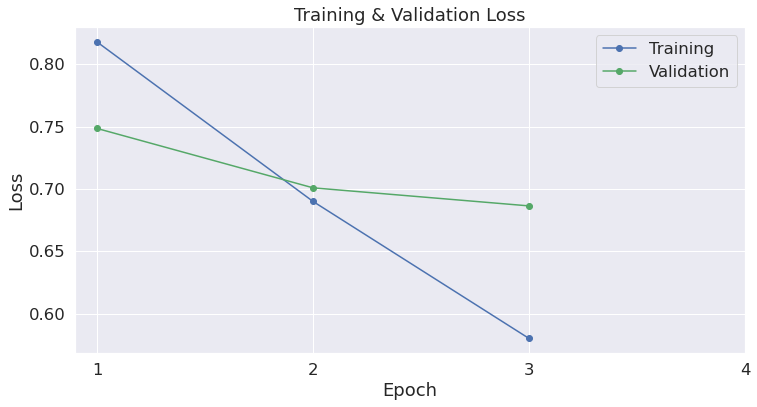

In [34]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [35]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 76 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072,

# Saving & Loading Fine-Tuned Model


In [36]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

#output_dir = './model_save/'
output_dir = './models'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
#tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./models


In [37]:
output_dir ='./models'

model.save_pretrained(output_dir)

In [38]:
export_path = './models'
torch.save(model, f'{export_path}/gpt2_v2.pt')
tokenizer.save_pretrained(export_path)

('./models/tokenizer_config.json',
 './models/special_tokens_map.json',
 './models/vocab.json',
 './models/merges.txt',
 './models/added_tokens.json')

# Generate Text

In [39]:
# Load a trained model and vocabulary that you have fine-tuned
model_dump_dir = "./models"
model = GPT2LMHeadModel.from_pretrained(model_dump_dir)
tokenizer = GPT2Tokenizer.from_pretrained(model_dump_dir)
device = torch.device("cuda")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [41]:
#test on sample
model.eval()
input_prompt = "What is (are) Breast Cancer ?"

prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 100,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: 
[WP] What is (are) Breast Cancer? 
[RESPONSE]bariatric canomyomyomy be the only treatments that can treat prostate cancer but breast cancer may be treatable (by removing the tube by laparoscopic surgery) or by surgery (when necessary).


1: 
[WP] What is (are) Breast Cancer? 
[RESPONSE]the term meaning breast cancer is in most of its forms. the names are used only on medical history from the time it was initially used to be used to describe breast cancer. there are no general term for breast cancer.


2: 
[WP] What is (are) Breast Cancer? 
[RESPONSE]hellohello dear. i am a board certified biofeedback specialist who has worked with multiple american academy of plastic surgery and the american society of plastic surgery and was the only source offeedback. the medical profession today paid attention to this attention whether it is a breast feeding or just breast feeding. after years and still no treatments are needed. i would suggest you to consult your doctor immediately




### Test on actual medquad test set

In [ ]:
import pandas as pd
import re

# Load the CSS dataset into a DataFrame
df = pd.read_csv('All-2479-Answers-retrieved-from-MedQuAD.csv')  # Replace 'your_dataset.csv' with the actual file name

# Create new columns for the extracted question and answer
df['Extracted_Question'] = ''
df['Extracted_Answer'] = ''

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    # Extract the question using regex
    question_match = re.search(r'Question: (.+)\n', row['Answer'], re.IGNORECASE)
    if question_match:
        question = question_match.group(1)
        df.at[index, 'Extracted_Question'] = question.strip()
    
    # Extract the answer using regex
    answer_match = re.search(r'Answer: (.+)', row['Answer'], re.IGNORECASE)
    if answer_match:
        answer = answer_match.group(1)
        df.at[index, 'Extracted_Answer'] = answer.strip()

# Save the updated DataFrame to a new dataset
df.to_csv('new_dataset.csv', index=False)  # Replace 'new_dataset.csv' with the desired file name


In [42]:
df_test = pd.read_csv('new_dataset.csv')

In [46]:
import re

In [51]:
model.eval()

def generate_gpt(input):
  input_prompt = input

  prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"
  #print(prompt)

  generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
  generated = generated.to(device)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 200,
                                  top_p=0.95, 
                                  num_return_sequences=1
                                  )
  #print(sample_outputs)
  generated_text = sample_outputs[0].tolist()  # Get the first element of the list
  ans = tokenizer.decode(generated_text, skip_special_tokens=True)
  response_match = re.search(r'\[RESPONSE\](.+)', ans, re.IGNORECASE)
  #print(ans)
  #print(sample_outputs)
  if response_match:
    response = response_match.group(1).strip()
    return response

In [52]:
df_test['Predictions']  = df_test['Extracted_Question'].apply(generate_gpt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [53]:
df_test.to_csv('new_dataset_tested.csv')